In [1]:
# Import packages
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import re
from wordcloud import WordCloud, STOPWORDS
import warnings
warnings.filterwarnings("ignore")
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

In [2]:
# import text data
df_data = pd.read_csv("Amazon_wsj_usa_today.csv")
df_data.set_index('Unnamed: 0', inplace=True)

In [3]:
# merge the two sources of news
df_data['news'] = df_data['WALL_STREE.text_last1days:amazon'] + df_data['USA_TODAY_.text_last1days:amazon']
df_data['count_news'] = df_data['WALL_STREE.text_COUNT_last1days:amazon'] + df_data['USA_TODAY_.text_COUNT_last1days:amazon']
df_final = pd.DataFrame()
df_final['news'] = df_data['news']
df_final['count_news'] = df_data['count_news']
df_final = df_final.set_index(pd.to_datetime(df_final.index))

In [4]:
# download stock price
import yfinance as yf
data_w = yf.download('AMZN', interval = "1wk", start="2016-01-01", end="2021-01-01")
data_sp = yf.download('^GSPC', interval = "1wk", start="2016-01-01", end="2021-01-01")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
# Compute forward log returns and excess returns
data_sp['log r'] = data_sp['Adj Close'].apply(np.log).diff()
data_sp['fwd log r'] = data_sp['log r'].shift(-1)
data_w['log r'] = data_w['Adj Close'].apply(np.log).diff()
data_w['fwd log r'] = data_w['log r'].shift(-1)
data_w['excess returns'] = data_w['fwd log r'] - data_sp['fwd log r']

In [6]:
# aggregate news to weekly
data_w['news'] = ''
data_w['count_news'] = 0
for t in range(len(data_w)):
    if t > 0:
        indeces_sel = (df_final.index>data_w.index[t-1])*(df_final.index<=data_w.index[t])
        data_w['news'][t] = df_final['news'][indeces_sel].sum()
        data_w['count_news'][t] = df_final['count_news'][indeces_sel].sum()

In [7]:
# Manipulate text data - clean it
data_w['cleaned_text'] = data_w['news']
for t in range(len(data_w['cleaned_text'])):
    # convert to lower case
    data_w['cleaned_text'][t] = data_w['cleaned_text'][t].lower()
    # take out non words
    data_w['cleaned_text'][t] = re.sub(r'\W',' ',data_w['cleaned_text'][t])
    # drop multiple spaces
    data_w['cleaned_text'][t] = re.sub(r'\s+',' ',data_w['cleaned_text'][t])
    # Remove stopwords (words that do not add any value) and empty
    this_sentence = [w for w in data_w['cleaned_text'][t].split(" ") if not w in STOPWORDS]
    data_w['cleaned_text'][t] = ' '.join(str(e) for e in this_sentence)

# Convert the column of the dataframe to a list
corpus = []
for j in range(len(data_w['cleaned_text'])):
    if data_w['cleaned_text'][j] != []:
        corpus.append(data_w['cleaned_text'][j])
    else:
        corpus.append('')        

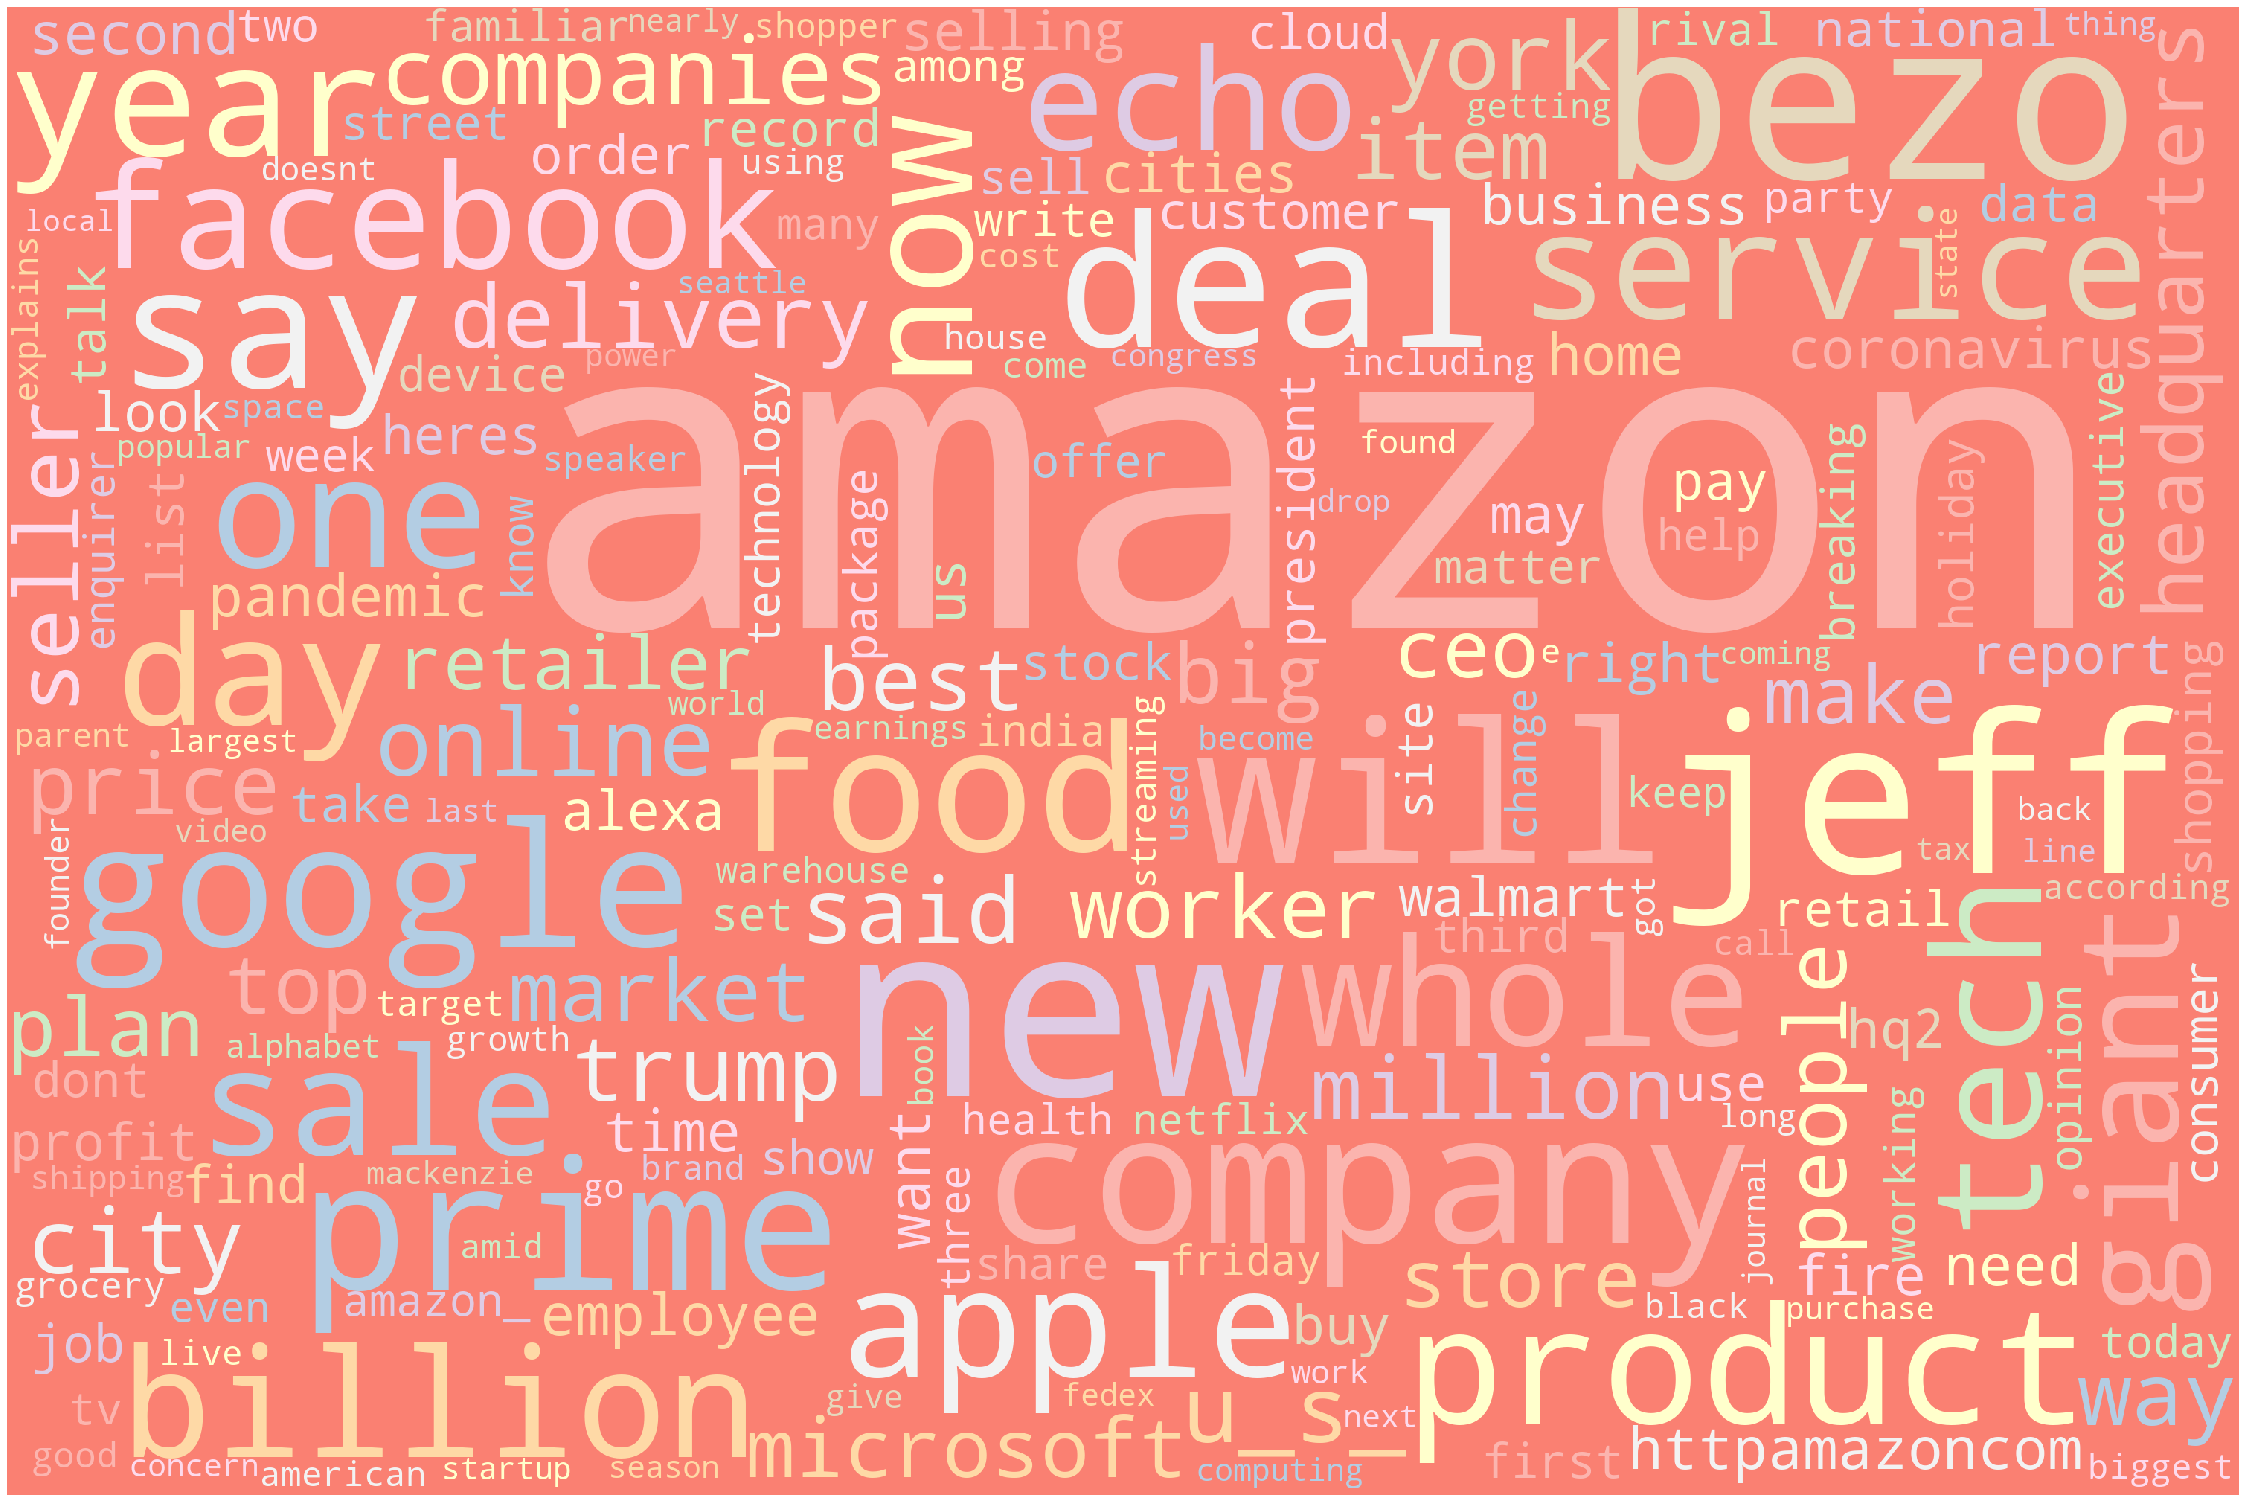

In [8]:
# Generate word cloud
str1 = ''
for this_list in corpus:
    str1 = str1 + this_list
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='salmon', colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(str1)
# Plot
plot_cloud(wordcloud)

In [9]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(use_idf=True)
X = vectorizer.fit_transform(corpus)
all_words = vectorizer.get_feature_names()

In [10]:
# Import dictionaries (words)
positives_LM = list(pd.read_csv("Positive.csv")["LM"].dropna())
negatives_LM = list(pd.read_csv("Negative.csv")["LM"].dropna())

In [11]:
# Function to map words to sentiment via the dictionary
from difflib import SequenceMatcher
def map_word_to_sent(list_all_words, positives, negatives, similarity_check = True):
    scores_array = np.zeros(len(list_all_words))
    for j, word in enumerate(list_all_words):
        if word in positives:
            scores_array[j] = 1
        elif word in negatives:
            scores_array[j] = -1
        # Otherwise (and if option activated - see below) check similarities
        else:
            # similarity check: https://kite.com/python/docs/difflib.SequenceMatcher.ratio
            # T is the total number of elements in both sequences, and M is the number of matches, ratio is: 2.0*M / T
            if similarity_check:
                # Select most similar word
                this_sim = 0
                for thisj in positives:
                    score_sim = SequenceMatcher(None, thisj, word).ratio()
                    if score_sim > this_sim : this_sim = score_sim
                scores_array[j] = this_sim
                # If similarity is less than 0.95 then check negatives as well
                if this_sim < 0.95:
                    for thisj in negatives:
                        score_sim = SequenceMatcher(None, thisj, word).ratio()
                        if score_sim > this_sim :
                            this_sim = score_sim
                            scores_array[j] = - this_sim
    return scores_array

In [12]:
# Map words to numbers
Doc_word_LM = map_word_to_sent(all_words, positives_LM, negatives_LM, similarity_check = False)
#Doc_word_LM_score_match = map_word_to_sent(all_words, positives_LM, negatives_LM, similarity_check = True)

In [13]:
# Gen sentiment indicator
data_w["sentiment_index_LM"] = X @ Doc_word_LM

In [14]:
df_final_results = pd.DataFrame()
df_final_results['excess returns'] = data_w['excess returns']
df_final_results["sentiment_index_LM"] = data_w["sentiment_index_LM"]
df_final_results["count_news"] = data_w["count_news"]
# drop periods with no news
df_final_results = df_final_results[df_final_results["count_news"]>0]
df_final_results.drop(["count_news"], axis=1, inplace=True)

In [15]:
drop_zero_sentiment = True
if drop_zero_sentiment:
    df_final_results = df_final_results[df_final_results["sentiment_index_LM"]!=0]

In [16]:
df_final_results.corr()

excess returns  sentiment_index_LM
excess returns            1.000000            0.075965
sentiment_index_LM        0.075965            1.000000

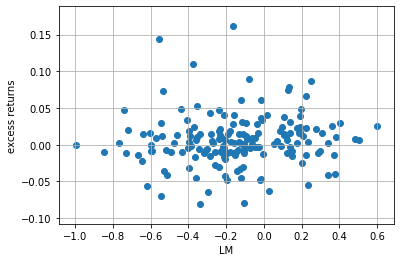

In [17]:
plt.scatter(df_final_results['sentiment_index_LM'], df_final_results['excess returns'])
plt.xlabel("LM");
plt.ylabel("excess returns");
plt.grid()

In [18]:
# Accuracy
print('Accuracy sentiment_index_LM for positive excess returns')
df_final_results['signal_long'] = (df_final_results['excess returns'] > 0)*1
accuracy_score = np.sum(df_final_results['signal_long']==(df_final_results['sentiment_index_LM']>0)*1)/len(df_final_results['signal_long'])
print(int(np.round(accuracy_score,2)*100), '%')

Accuracy sentiment_index_LM for positive excess returns
56 %
